# 고양이 수염 스티커 만들기

## 1. 사진 준비하기

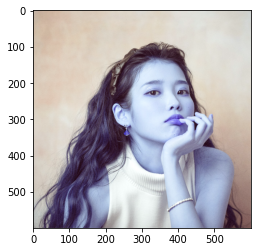

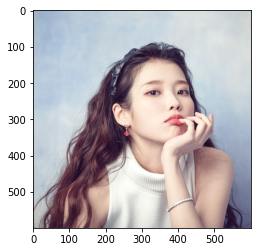

In [365]:
import os
import cv2 # opencv특징(RGB가 아닌 BGR) 때문에 
import matplotlib.pyplot as plt
import numpy as np
import dlib

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/iuimage.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기 떄문에 이미지 변색
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #pit.imshow 이전에 RGB로 바꿔야함
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 & 랜드마크 검출하기

rectangles[[(283, 160) (469, 345)]]


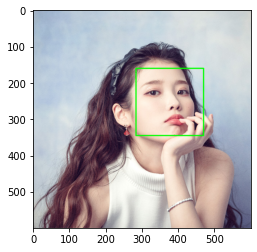

In [366]:
# 얼굴 검출 하기
# dlib을 사용해 hog detector 선언하는법
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # detector_hog를 이용해서 얼굴의 bounding box(박스형태로 위치를 표시)를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # cvtColor를 이용해 RGB로 변환
dlib_rects = detector_hog(img_rgb, 1)   # (image, 이미지 피라미드 수)


print(dlib_rects) # 찾은 얼굴 화면에 출력, 찾을 얼굴영역 좌표  

for dlib_rect in dlib_rects: # dlib detector는 dlib.rectangles 타입의 객체를 반환 / dlib.rectangles는 배열 형태
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


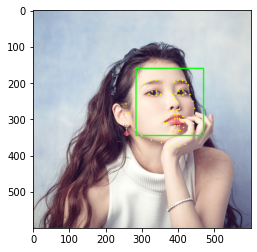

In [367]:
# 랜드마크 검출 하기
# Dlib의 제공되는 모델을 사용 landmark 모델을 불러옵니다
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects: # dlib.full_object_detection 를 반환
    points = landmark_predictor(img_rgb, dlib_rect) # (RGB 이미지, dlib.rectangle)
    # points 는 dlib.full_object_detection 의 객체이기 때문에 face landmark 좌표를 저장해둡니다    
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) 
    # parts()로 개별 위치에 접근가능 / 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환
    # list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다
    list_landmarks.append(list_points) # 이미지에서 찾아진 얼굴 개수마다 반복하면

print(len(list_landmarks[0]))  # list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장

# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인하기

In [368]:
# 좌표확인 하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코끝은 인덱스 33
    x = landmark[33][0] 
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(394, 275)
(x,y) : (394,275)
(w,h) : (187,187)


현재까지는 좌표 위치를 계산하고 설정하는 것에 익숙하지 못하여서 랜드마크 사진에 있는 번호를 지정하여 높이를 조정하여서 코위치를 맞췄다
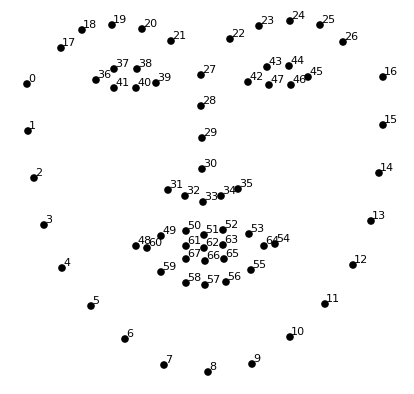

In [369]:
# 좌표 위치 변경한 위치 나타내기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whisker.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 윗 단계에서 계산한 크기로 resize

print (img_sticker.shape)  

(187, 187, 3)


In [370]:
# 스티커가 이미지가 사진 이미지 규격에서 벗어나는지 확인
refined_x = x - w // 2
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # y축이 음수가 생기는 문제가 발생함
# 음수는 이미지 밖으로 스티커가 삐져나갔다는 뜻
# opencv 데이터는 numpy ndarray 형태의 데이터를 사용하는데 
# ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다

(x,y) : (301,182)


In [371]:
# 원본 이미지에 스티커 적용

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    # img_sticker에 0이 아닌 255를 넣으니 하얀 배경색이 없어지고 
# img_show[from:to] 형식입니다
# 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 
# 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 
# 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

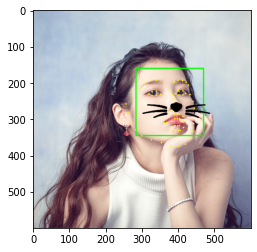

In [372]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

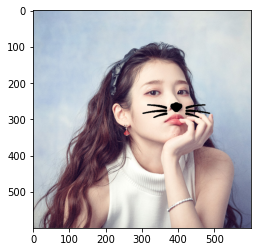

In [373]:
# bounding box와 landmark 지우고 이미지 결과만 출력
# img_show 대신, img_rgb를 활용
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석해보자

어두운 이미지

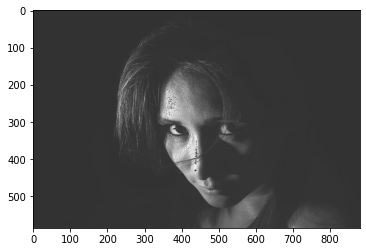

In [374]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dark.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = img_bgr+50
img_show = img_bgr.copy()      

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()


# 이미지 밝기 조절이라해서 이거 해보는데 오류뜨고 오류 안뜨게 하니까 데드 커널 뜨면서 안됨
#src = cv2.imread(my_image_path, cv2.IMREAD_GRAYSCALE) 
#add_dst = cv2.add(src, 100)
#sub_dst = cv2.substract(src, 100)
#cv2.imshow('src', src)
#cv2.imshow('add_dst', add_dst)
#cv2.imshow('sub_dst', sub_dst)

어두운 사진이라 흑백밖에 안들어가서 rgb로 바꿔도 차이를 느끼지 못함

rectangles[]


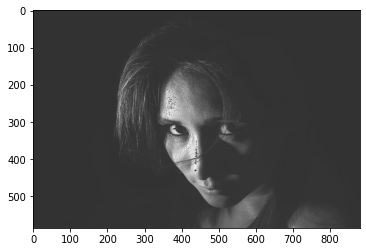

In [375]:
# 얼굴 검출 하기
# dlib을 사용해 hog detector 선언하는법
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # detector_hog를 이용해서 얼굴의 bounding box(박스형태로 위치를 표시)를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # cvtColor를 이용해 RGB로 변환
dlib_rects = detector_hog(img_rgb, 1)   # 숫자 2로 바꾸니까 박스 2개로 생김


print(dlib_rects) # 찾은 얼굴 화면에 출력, 찾을 얼굴영역 좌표  

for dlib_rect in dlib_rects:
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

어두워서 박스를 못만들고 rectangle[]이 비어있음

사진 밝기를 밝게 해봤는데 그래도 안됨

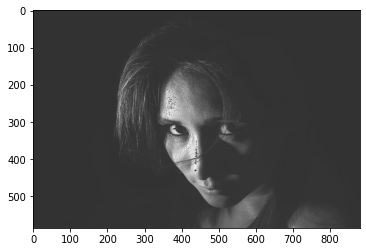

In [376]:
# 랜드마크 검출 하기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects: 
    points = landmark_predictor(img_rgb, dlib_rect) 
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) 
    list_landmarks.append(list_points) # 이미지에서 찾아진 얼굴 개수마다 반복하면

# print(len(list_landmarks[0])) 오류 떠서 주석 다니까 사진은 나옴 근데 바운딩박스랑 랜드마크 검출 안됨 빈 리스트라 0번 찾을수없음

# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [377]:
# 좌표확인 하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코끝은 인덱스 33
    x = landmark[33][0] 
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

In [378]:
# 좌표 위치 변경한 위치 나타내기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whisker.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 윗 단계에서 계산한 크기로 resize

print (img_sticker.shape)  

(187, 187, 3)


In [379]:
# 스티커가 이미지가 사진 이미지 규격에서 벗어나는지 확인
refined_x = x - w // 2
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (301,182)


In [380]:
# 원본 이미지에 스티커 적용
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 

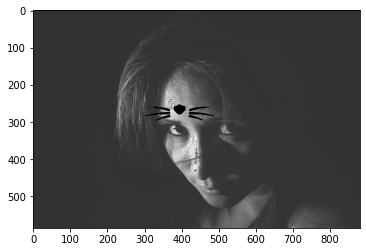

In [381]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

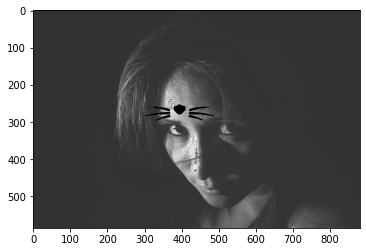

In [382]:
# bounding box와 landmark 지우고 이미지 결과만 출력
# img_show 대신, img_rgb를 활용
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

어두워서 박스랑 랜드마크 검출 하지 못하고 수염이 나오긴 하지만 이상한데 가있음

여러명 있는 사진

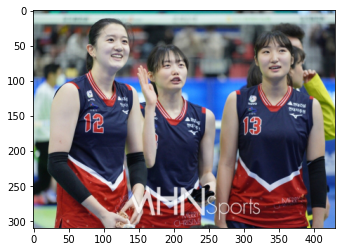

In [383]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hyun.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = img_bgr
img_show = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

rectangles[[(95, 26) (147, 78)], [(180, 65) (223, 108)], [(319, 44) (371, 95)]]


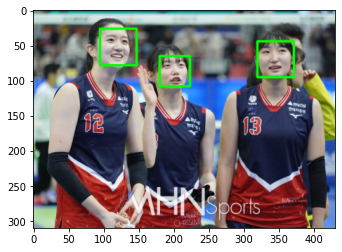

In [384]:
# 얼굴 검출 하기

detector_hog = dlib.get_frontal_face_detector() 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
dlib_rects = detector_hog(img_rgb, 1)  


print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

68


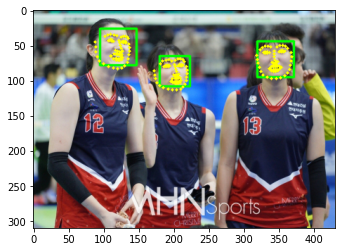

In [385]:
# 랜드마크 검출 하기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects: 
    points = landmark_predictor(img_rgb, dlib_rect) 
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) 
    list_landmarks.append(list_points) # 이미지에서 찾아진 얼굴 개수마다 반복하면
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for i in range(len(list_landmarks)):
        for idx, point in enumerate(list_landmarks[i]):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)                                    

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [386]:
w = dlib_rect.width()
h = dlib_rect.width()
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape) 

(53, 53, 3)


In [387]:
# 좌표확인 하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코끝은 인덱스 33
    x = landmark[33][0]
    y = landmark[33][1]
    refined_x = int(x - w//2)      
    refined_y = int(y - w//2)     
#    w = dlib_rect.width()
#    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(123, 59)
(x,y) : (123,59)
(w,h) : (53,53)
(204, 92)
(x,y) : (204,92)
(w,h) : (53,53)
(344, 75)
(x,y) : (344,75)
(w,h) : (53,53)


In [388]:
# 좌표 위치 변경한 위치 나타내기
#sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whisker.png'
#img_sticker = cv2.imread(sticker_path)
#img_sticker = cv2.resize(img_sticker, (w,h)) 
#print (img_sticker.shape)  

In [389]:
# 스티커가 이미지가 사진 이미지 규격에서 벗어나는지 확인
#refined_x = x - w // 2
#refined_y = y - h // 2 
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [390]:
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
   np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 


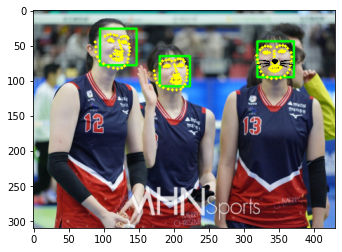

In [391]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

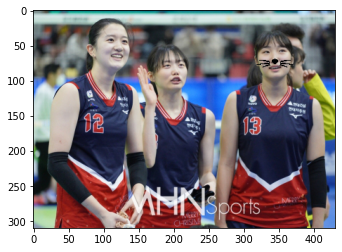

In [392]:
# bounding box와 landmark 지우고 이미지 결과만 출력
# img_show 대신, img_rgb를 활용
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
평범한 사진 준비, 얼굴 검출, 랜드마크 검출을 하는데 큰 문제는 없었으나 고양이 수염을 불러와서 고양이 수염 불러왔을때 하얀색 배경이 있었는데 np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) 이부분에서 img_sticker에서 255의 값을 주니 수염이 제대로 나와서 완성 시킬수 있었다

어두운 사진은 얼굴 검출과 랜드마크 검출을 하는데 문제가 생김

여러명 있는 사진은 얼굴 검출과 랜드마크 검출 하는데 문제가 없지만 스티커가 한명에게만 붙는 문제가 발생 찾아보고 따라해보는데도 안되는데 왜 안되는지 모르겠음